In [1]:
import os.path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, binary_erosion, binary_dilation , binary_closing, binary_opening
from skimage.color import rgb2gray #http://scikit-image.org/docs/dev/api/skimage.color.html
from skimage.filters import threshold_otsu

# Load image for processing

cough.png


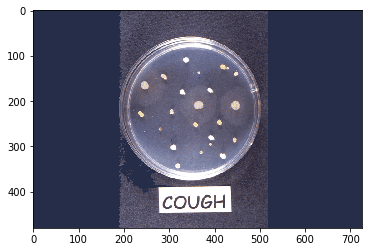

In [2]:
!ls images
imgf='images/cough.png'
img_pil = Image.open(imgf)
img_np = np.asarray(img_pil)
img_pil.close()
plt.imshow(img_np);plt.show()

### Turn the image into grayscale

(480, 725)


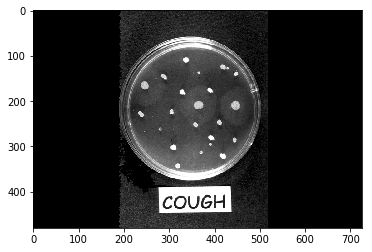

In [3]:

gray_np = rgb2gray(img_np)
print(gray_np.shape)
plt.imshow(gray_np,cmap="gray");plt.show()

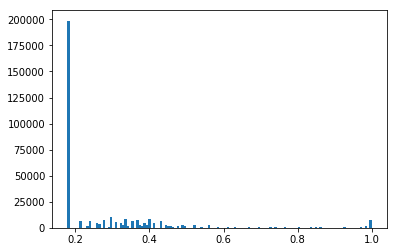

In [4]:
plt.hist(gray_np.flatten(),bins=128);plt.show()

### Find the best binarization threshold

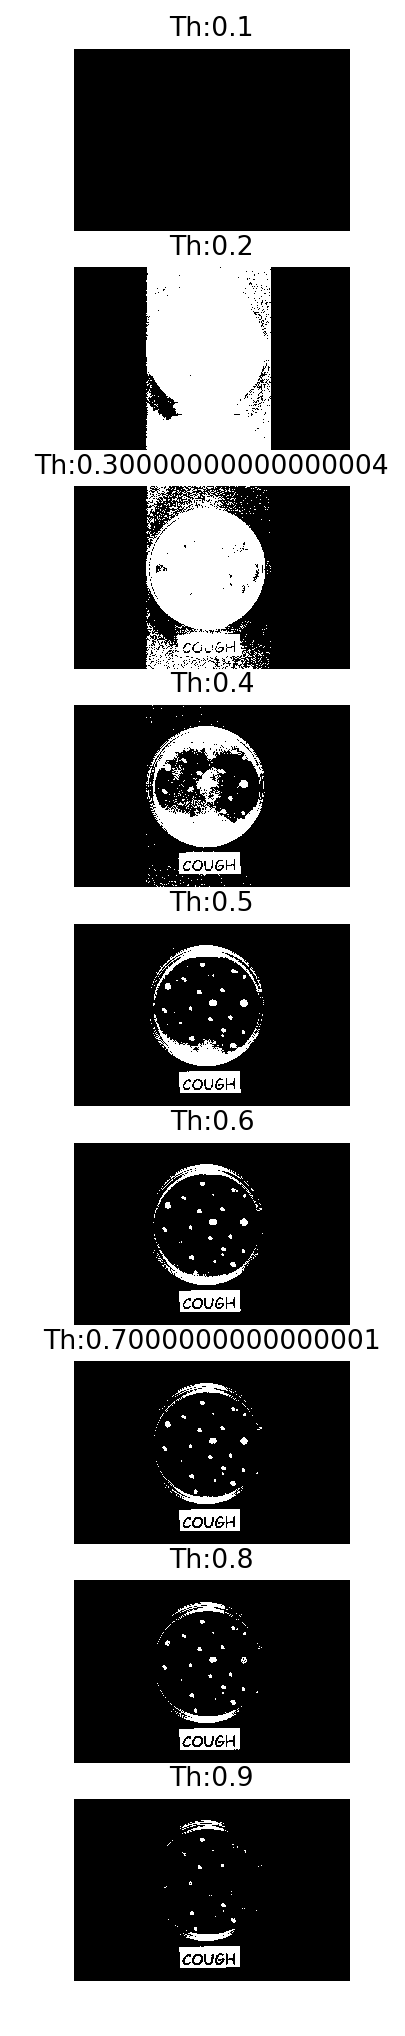

In [5]:
ths = np.arange(0.1,1,0.1)
ths_n = ths.shape[0]
fig = plt.figure(figsize=(10,16),dpi=160)
for _,th in enumerate(ths):
    tmp_np=gray_np.copy()
    tmp_np[tmp_np<th]=0
    tmp_np[tmp_np>=th]=1
    plt.subplot(ths_n,1,_+1)
    plt.title("Th:"+str(th))
    plt.imshow(tmp_np,cmap="gray")
    plt.axis('off')

plt.show()

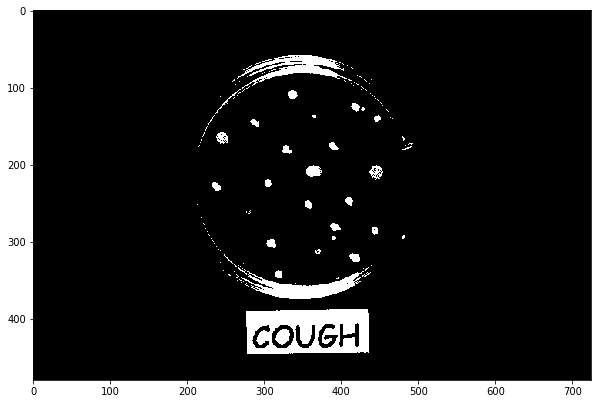

In [6]:
#With a Th: 0.8
th_np = gray_np.copy()
th_np[th_np<0.8]=0
th_np[th_np>=0.8]=1

fig = plt.figure(figsize=(10,10))
plt.imshow(th_np,cmap='gray');plt.show()



In [7]:
### Evaluating Erosion of  objects

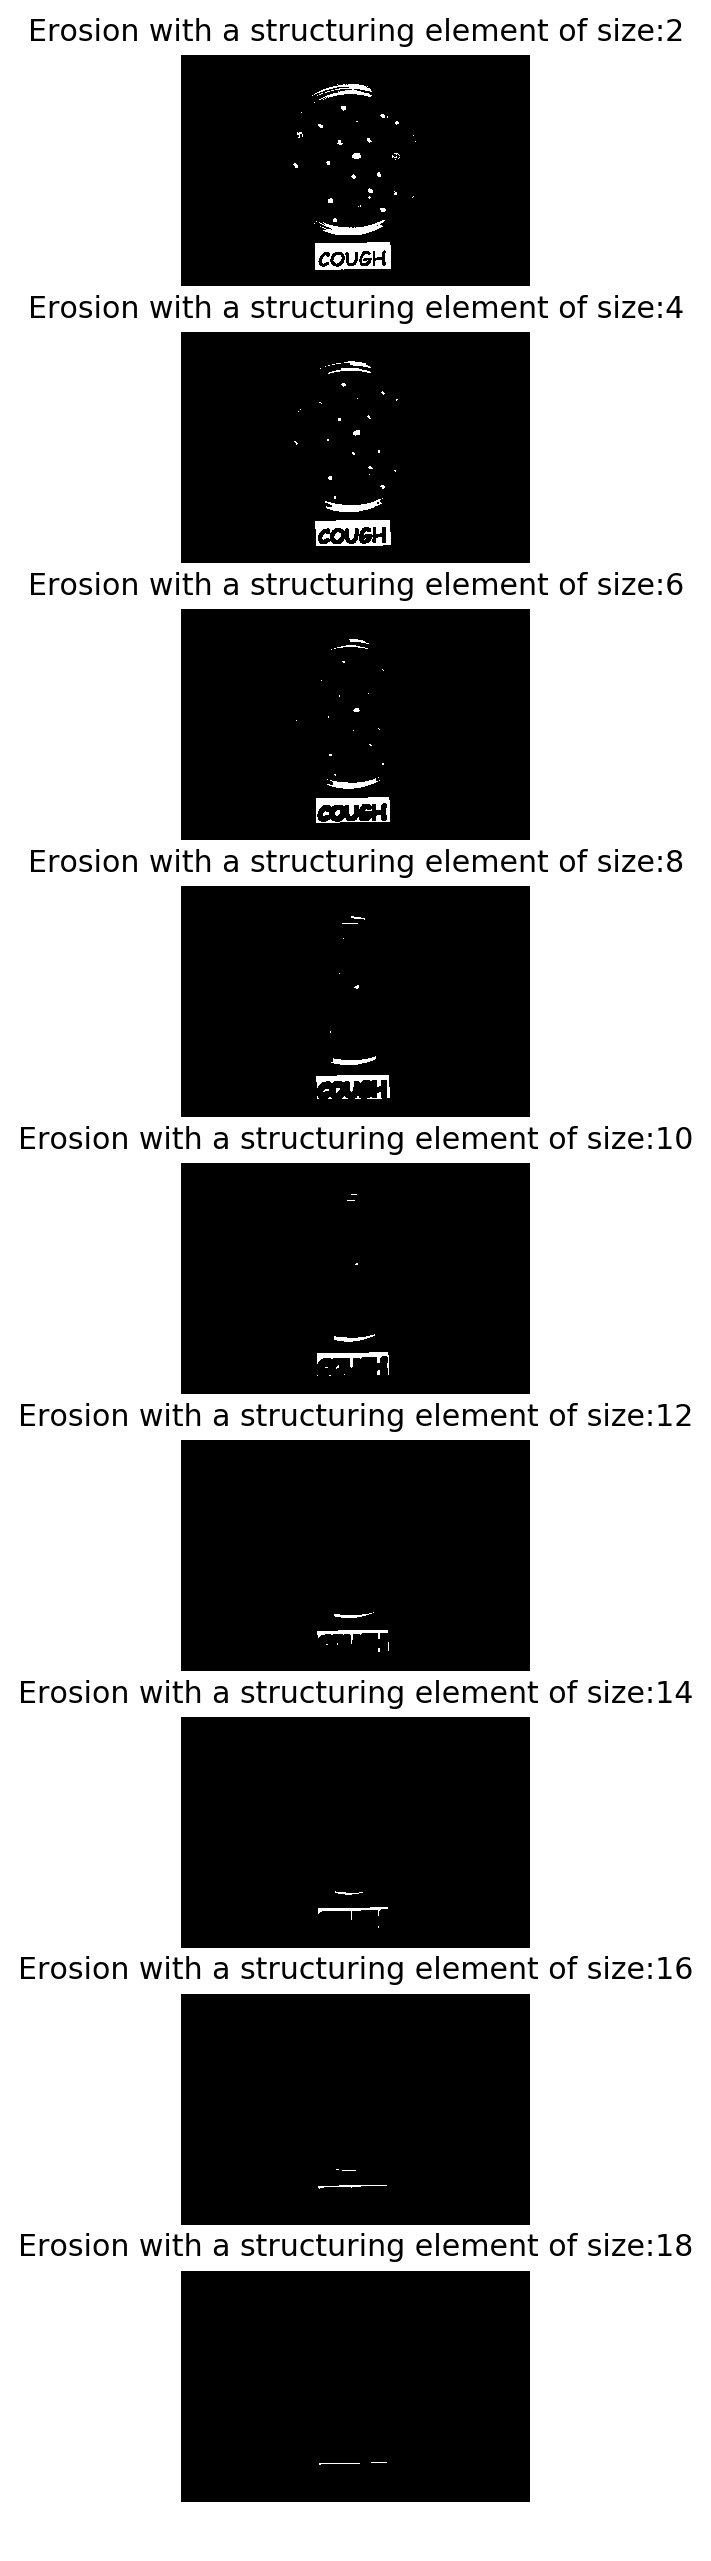

In [8]:
def plot_sequence(inps,iranges,ititles,figsize=(10,10),dpi=90):
    irangen = iranges.shape[0]
    fig = plt.figure(figsize=(figsize[0],irangen*2),dpi=dpi)
    for __,_ in enumerate(iranges):
        plt.subplot(irangen,1,__+1)
        plt.title(ititles[__])
        plt.imshow(inps[__],cmap='gray')
        plt.axis('off')
    plt.show()    


sqs = np.arange(2,20,2)
erosions=[]
ero_titles = []
for __,_ in enumerate(sqs):
    se = square(_) #structuring element
    erosions.append(binary_erosion(th_np,se))
    ero_titles.append("Erosion with a structuring element of size:"+str(_))

plot_sequence(erosions,sqs,ero_titles,figsize=(12,12),dpi=180)


### Evaluating dilation of objects 

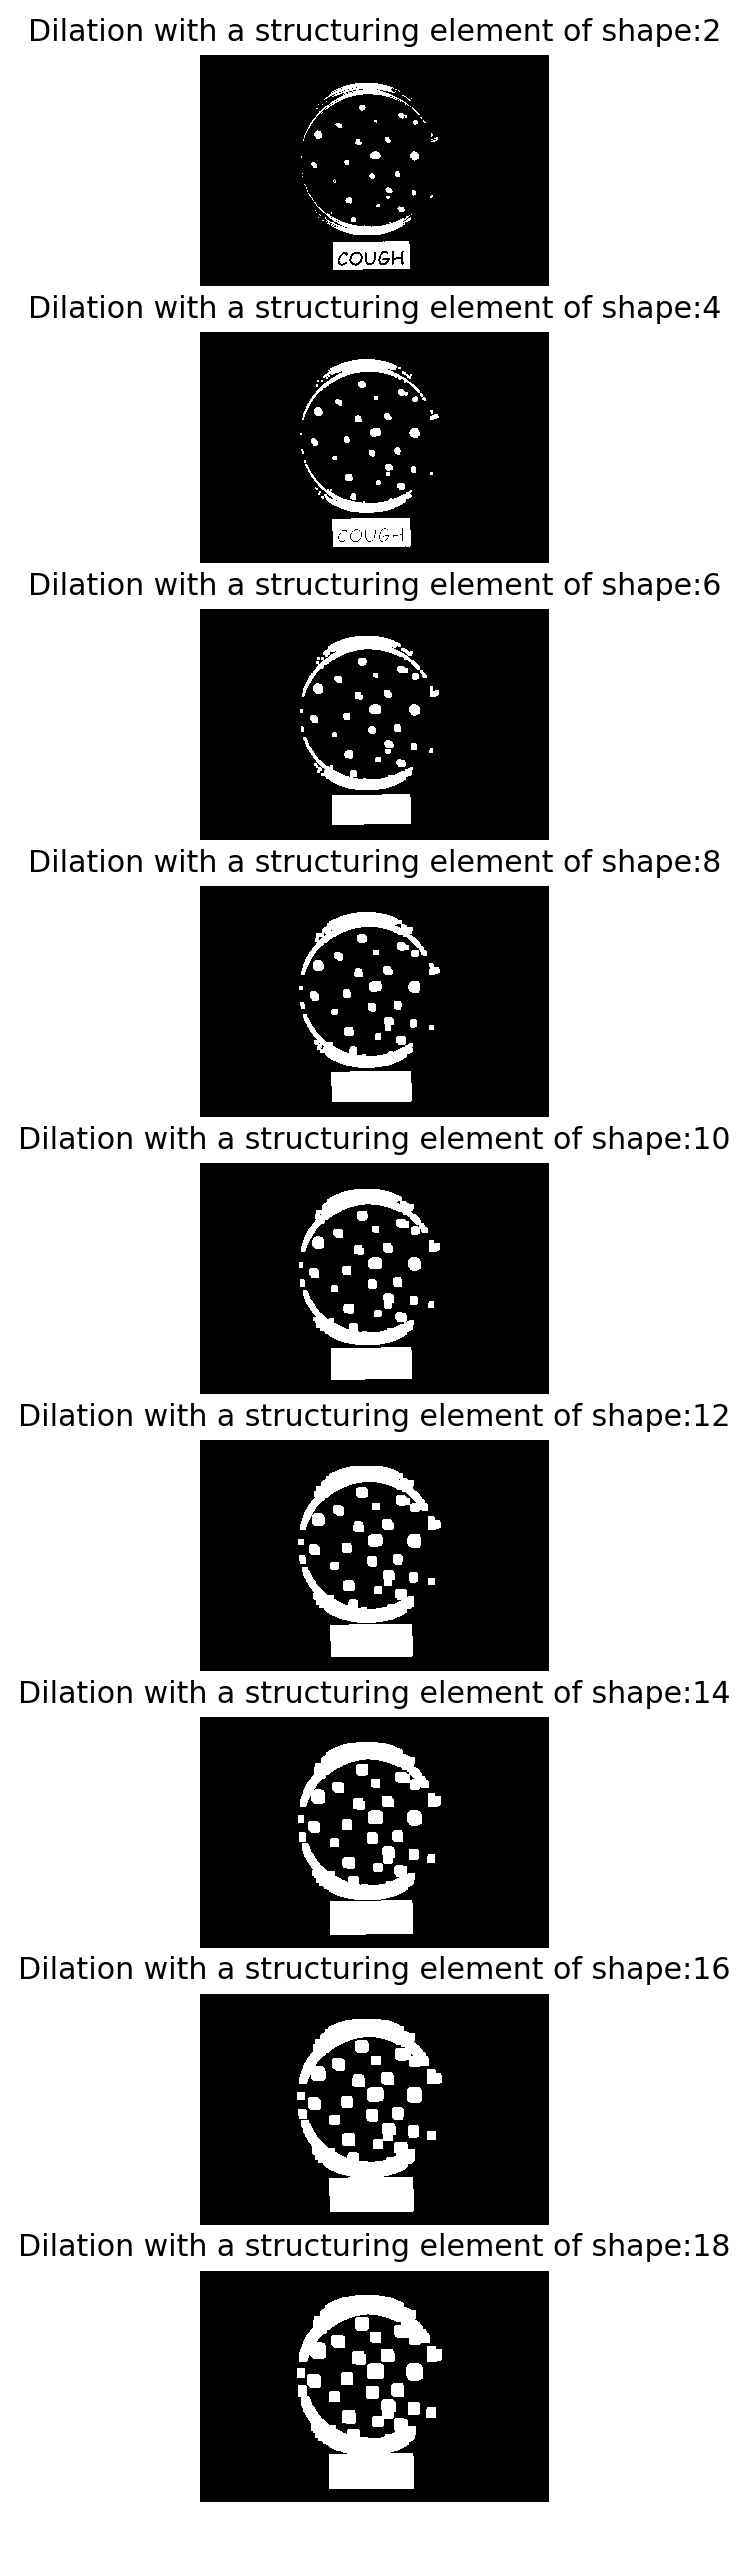

In [9]:

sqs = np.arange(2,20,2)
dilations=[]
dil_titles = []
for __,_ in enumerate(sqs):
    se = square(_) #structuring element
    dilations.append(binary_dilation(th_np,se))
    dil_titles.append("Dilation with a structuring element of shape:"+str(_))

plot_sequence(dilations,sqs,dil_titles,figsize=(12,12),dpi=180)


### Opening of an image: erosion followed by an dilation 

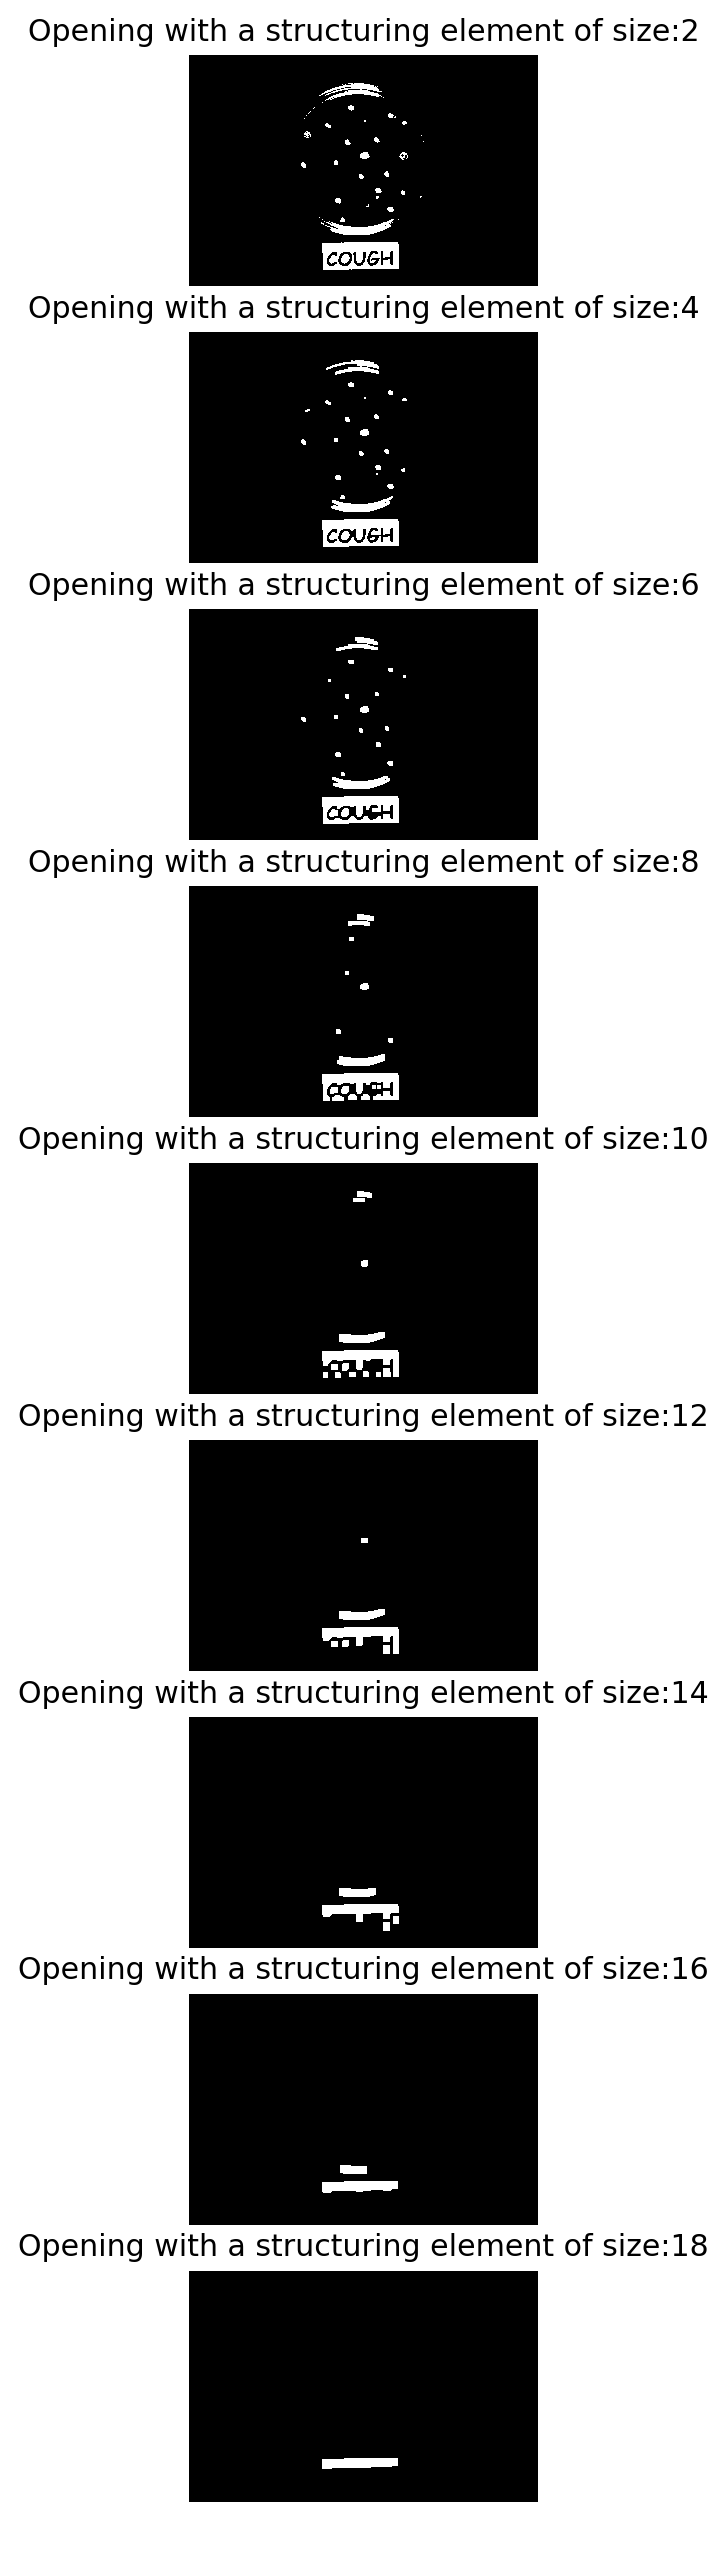

In [10]:
sqs = np.arange(2,20,2)
openings=[]
op_titles = []
for __,_ in enumerate(sqs):
    se = square(_) #structuring element
    openings.append(binary_opening(th_np,se))
    op_titles.append("Opening with a structuring element of size:"+str(_))

plot_sequence(openings,sqs,op_titles,figsize=(12,12),dpi=180)


In [11]:
### Closing of an image: Dilation followed by an erosion

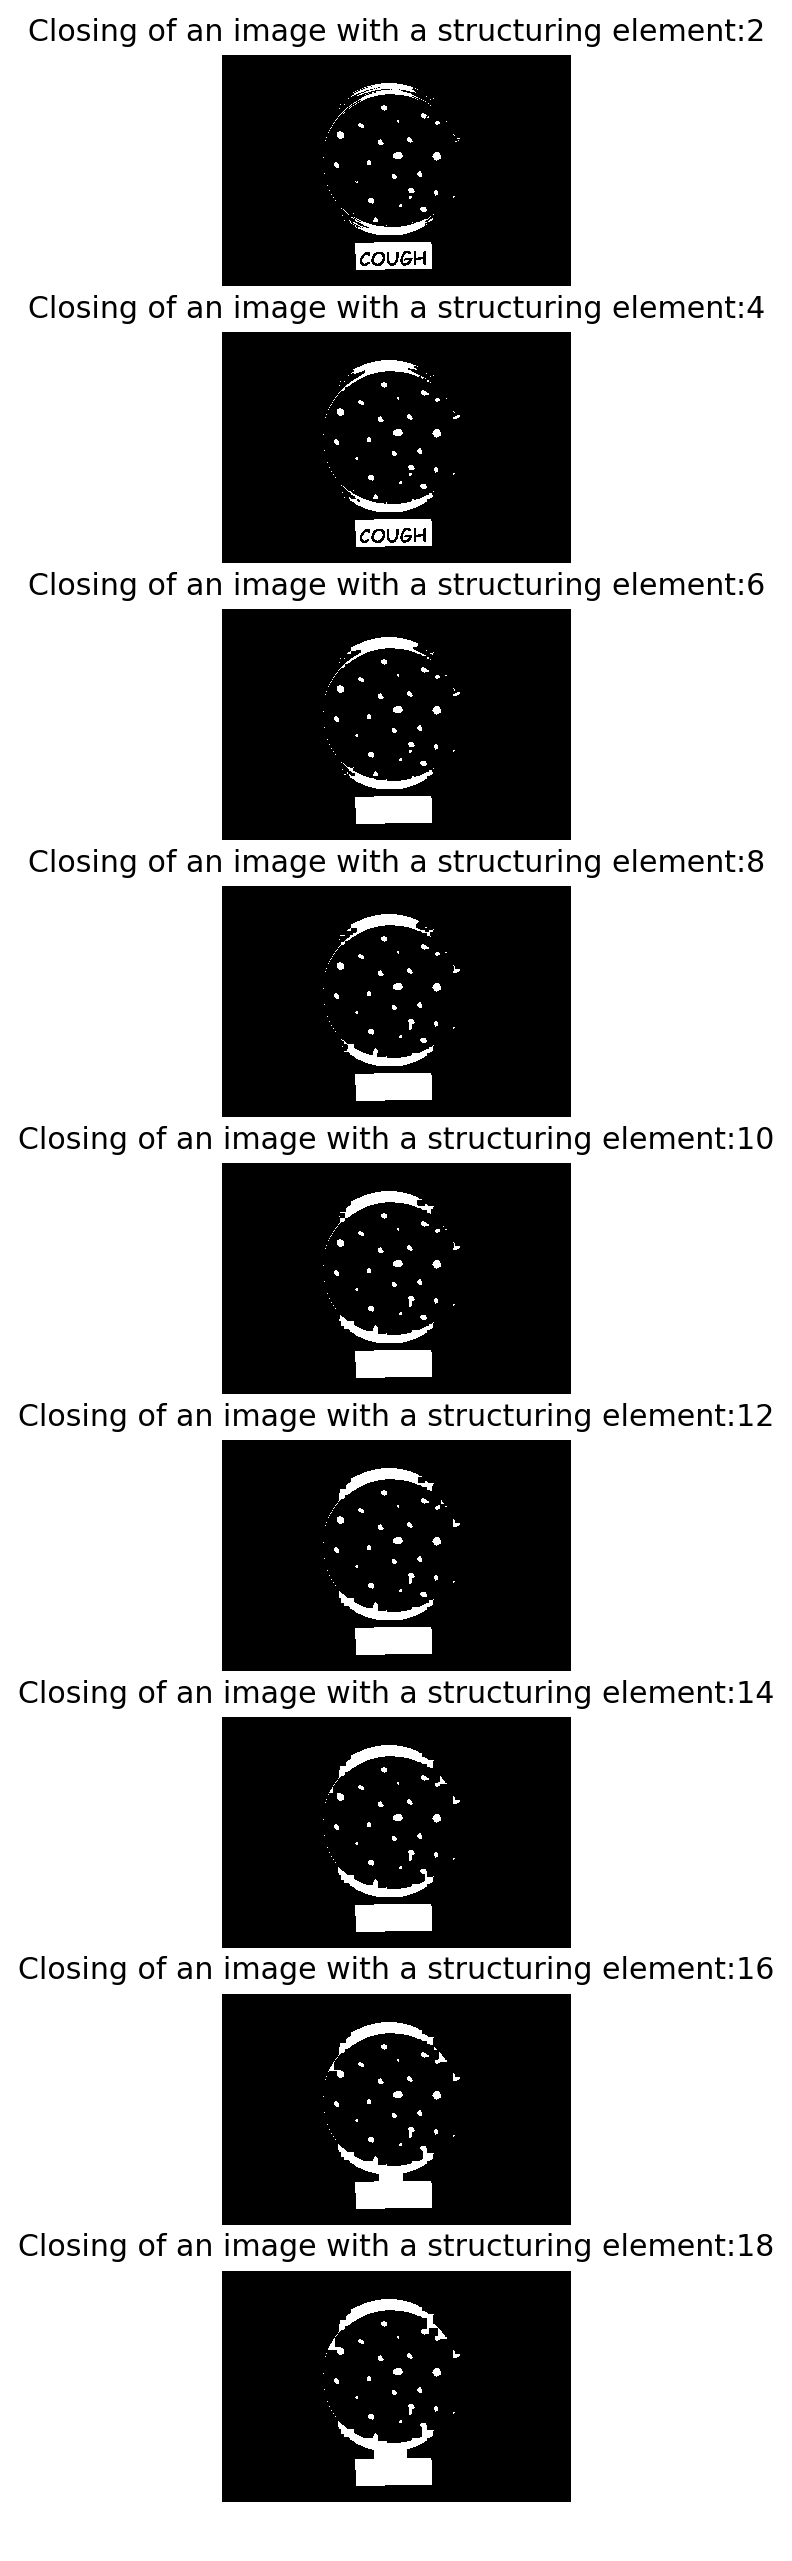

In [12]:
sqs = np.arange(2,20,2)
closings=[]
cl_titles = []
for __,_ in enumerate(sqs):
    se = square(_) #structuring element
    closings.append(binary_closing(th_np,se))
    cl_titles.append("Closing of an image with a structuring element:"+str(_))

plot_sequence(closings,sqs,cl_titles,figsize=(12,12),dpi=180)


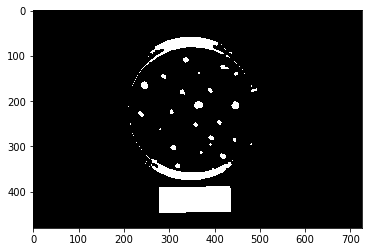

In [13]:
closed_np = binary_closing(th_np,square(6))
plt.imshow(closed_np,cmap='gray');plt.show()

### Finding objects that are closed 

In [14]:
labeled_np = label(closed_np)
total_objects = np.unique(labeled_np)
print("Total objects",total_objects[-1]+1)


Total objects 77


Keeping objects with an area bigger than 4 pixels of side and smaller than 10.

In [15]:
min_pixel_area=4*4
max_pixel_area=10*10

valid_regions = []
for region in regionprops(labeled_np):
    if (region.area<max_pixel_area) and (region.area>min_pixel_area):
        valid_regions.append(region.bbox)

print(len(valid_regions))


14


Showing the result in the final image

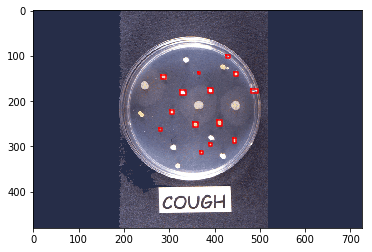

In [16]:
#help(mpatches.Rectangle)
def bbox_to_plt_rect(ibbox):
    min_row,min_col,max_row,max_col = ibbox
    xs = [min_col,max_col,max_col,min_col,min_col]
    ys = [min_row,min_row,max_row,max_row,min_row]
    return xs[:],ys[:]

rects = list(map(bbox_to_plt_rect,valid_regions))
plt.imshow(img_np)
for rect in rects:
    plt.plot(rect[0],rect[1],color='red')
plt.show()

## Setting everything together

Detected objects: 23


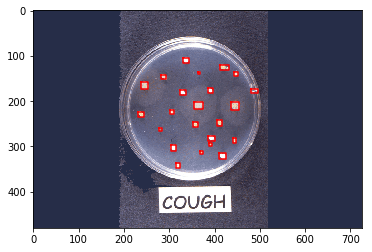

In [17]:
def find_objs(image_file,binary_th=None,structuring_element_shape=6,
              min_pixel_area=4*4,
            max_pixel_area=10*10):
    if not os.path.isfile(image_file):
        print("file does not exist")
        return None
    def bbox_to_plt_rect(ibbox):
        min_row,min_col,max_row,max_col = ibbox.bbox
        xs = [min_col,max_col,max_col,min_col,min_col]
        ys = [min_row,min_row,max_row,max_row,min_row]
        return xs[:],ys[:]
    _pi = Image.open(image_file)
    _inp = np.asarray(_pi)
    _pi.close()
    _g = rgb2gray(_inp)
    if type(binary_th)==type(None):
        _th = threshold_otsu(_g)
    else:
        _th = binary_th
    _g[_g<_th]=0
    _g[_g>=_th]=1
    _c = binary_closing(_g,square(structuring_element_shape))
    _l = label(_c)
    _regions = regionprops(_l)
    _ba = lambda x: (x.area<max_pixel_area) and (x.area>min_pixel_area)
    _valid_regions = list(filter(_ba,_regions))
    _rects = list(map(bbox_to_plt_rect,_valid_regions))
    _o = {'np_img':_inp.copy(),'boxes_ys_xs_ye_xe':_valid_regions[:],"box":_rects[:]}
    return _o.copy()

procs = find_objs(imgf, binary_th=0.8,structuring_element_shape=4,
              min_pixel_area=4*4,
            max_pixel_area=16*16)
print("Detected objects:",str(len(procs['box'])))
plt.imshow(procs['np_img']);
for box in procs['box']:
    plt.plot(box[0],box[1],color='red')
plt.show()

# References:  
* http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops
* http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label
* https://microbiologyonline.org/teachers/observing-microbes/observing-bacteria-in-a-petri-dish
* https://microbiologyonline.org/file/large/a7f6bd8a062f8ab284da3bc1985082f9.png
* http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html
* http://scikit-image.org/docs/dev/api/skimage.color.html
* http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu
* http://scikit-image.org/docs/dev/api/skimage.filters.html
* http://scikit-image.org/docs/dev/api/skimage.morphology.html
* http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.binary_opening